In [ ]:

print("Hello ")

: 

In [ ]:
pip install tensorflow


: 

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.optimizers import Adam

: 

In [4]:
# Load dataset
file_path = '/content/drive/MyDrive/DeepLearning/DataSet/TamilDatasetGrammar.xlsx'
df = pd.read_excel(file_path)

# Clean dataset
df = df.dropna(subset=['Original Sentence', 'Corrected Sentence'])
df['Original Sentence'] = df['Original Sentence'].astype(str).str.strip()
df['Corrected Sentence'] = df['Corrected Sentence'].astype(str).str.strip()


: 

In [5]:

# Add start and end tokens for decoding
input_sentences = df['Original Sentence'].values
target_sentences = ['<start> ' + sentence + ' <end>' for sentence in df['Corrected Sentence'].values]

# Tokenize input and target sentences
input_tokenizer = Tokenizer(filters='', oov_token='<unk>')
input_tokenizer.fit_on_texts(input_sentences)
input_sequences = input_tokenizer.texts_to_sequences(input_sentences)

output_tokenizer = Tokenizer(filters='', oov_token='<unk>')
output_tokenizer.fit_on_texts(target_sentences)
target_sequences = output_tokenizer.texts_to_sequences(target_sentences)


: 

In [6]:
# Vocabulary sizes
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

# Maximum sequence lengths
max_input_length = max(len(seq) for seq in input_sequences)
max_target_length = max(len(seq) for seq in target_sequences)

# Pad sequences
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_length, padding='post')

# Decoder output data
decoder_output_data = np.zeros((len(target_sequences), max_target_length, output_vocab_size), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, word_id in enumerate(seq):
        if t > 0:  # Skip the first token
            decoder_output_data[i, t - 1, word_id] = 1.0


: 

In [7]:
# Train-test split
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_output_data, test_size=0.2, random_state=42)

# Model parameters
embedding_dim = 512  # Increased embedding dimension
hidden_units = 1024  # Increased hidden units
learning_rate = 0.001  # Adjusted learning rate


In [8]:
# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(hidden_units, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_target_length,))
decoder_embedding = Embedding(output_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [9]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)  # Optimized Adam
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 100  # Increased epochs for better learning

history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([encoder_input_val, decoder_input_val], decoder_output_val)
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.0897 - loss: 4.5890 - val_accuracy: 0.1429 - val_loss: 3.8636
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.1516 - loss: 4.0524 - val_accuracy: 0.1802 - val_loss: 4.4238
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1924 - loss: 4.3053 - val_accuracy: 0.1818 - val_loss: 3.9076
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.1898 - loss: 3.6749 - val_accuracy: 0.1818 - val_loss: 3.6900
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1897 - loss: 3.4297 - val_accuracy: 0.1818 - val_loss: 3.5839
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1966 - loss: 3.1926 - val_accuracy: 0.1916 - val_loss: 3.4187
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2053 - loss: 2.9734 - val_accuracy: 0.2175 - val_loss: 3.2574
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2451 - loss: 2.6480 - val_accuracy: 0.2321 - val_loss: 3.1389
Epoc

In [10]:
import os
import pickle
from tensorflow.keras.models import load_model

# Function to save models in h5 format and tokenizers in pickle format
def save_models_and_tokenizers(encoder_model, decoder_model, input_tokenizer, output_tokenizer, base_path='models/'):
    os.makedirs(base_path, exist_ok=True)  # Create the directory if it does not exist

    # Save models
    encoder_model_path = os.path.join(base_path, 'encoder_model.h5')
    decoder_model_path = os.path.join(base_path, 'decoder_model.h5')
    encoder_model.save(encoder_model_path)
    decoder_model.save(decoder_model_path)

    # Save tokenizers
    input_tokenizer_path = os.path.join(base_path, 'input_tokenizer.pkl')
    output_tokenizer_path = os.path.join(base_path, 'output_tokenizer.pkl')
    with open(input_tokenizer_path, 'wb') as handle:
        pickle.dump(input_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(output_tokenizer_path, 'wb') as handle:
        pickle.dump(output_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Models and tokenizers have been saved successfully.")

# Call the function with the models and tokenizers
save_models_and_tokenizers(encoder_model, decoder_model, input_tokenizer, output_tokenizer)


NameError: name 'encoder_model' is not defined

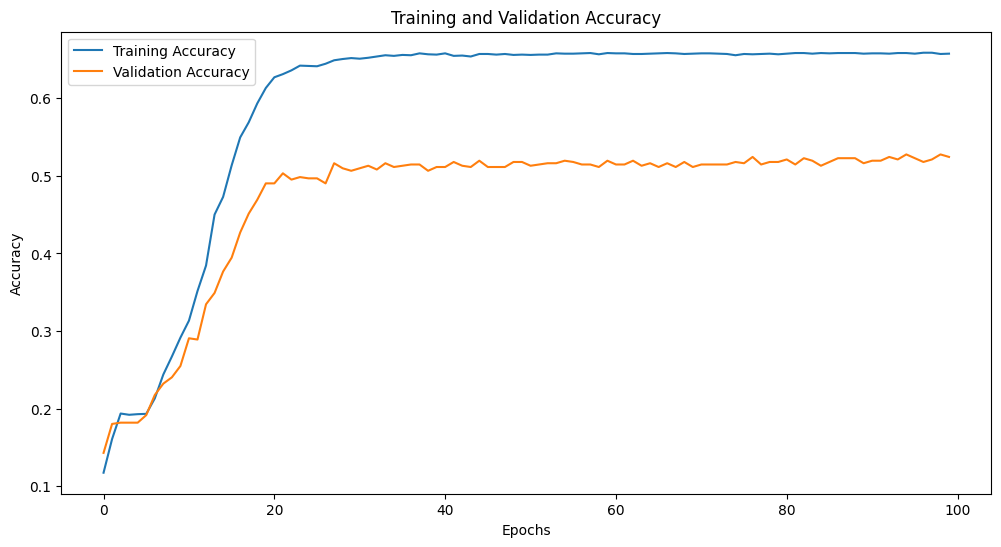

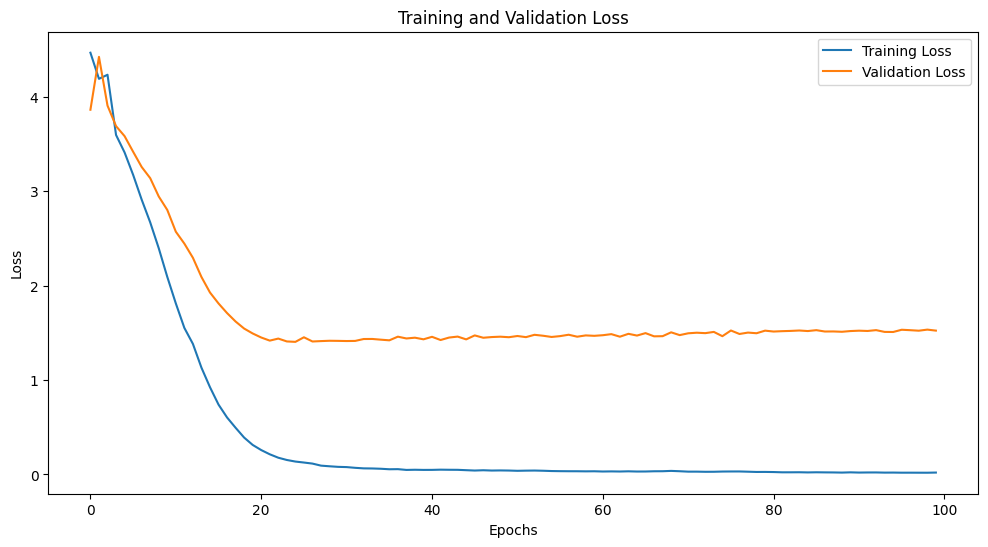

In [11]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding_inf = Embedding(output_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Decode function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_tokenizer.word_index['<start>']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = output_tokenizer.index_word.get(sampled_token_index, '<unk>')
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_target_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.strip()


In [18]:
import os
import pickle
from tensorflow.keras.models import load_model

# Function to save models in h5 format and tokenizers in pickle format
def save_models_and_tokenizers(encoder_model, decoder_model, input_tokenizer, output_tokenizer, base_path='models/'):
    os.makedirs(base_path, exist_ok=True)  # Create the directory if it does not exist

    # Save models
    encoder_model_path = os.path.join(base_path, 'encoder_model.h5')
    decoder_model_path = os.path.join(base_path, 'decoder_model.h5')
    encoder_model.save(encoder_model_path)
    decoder_model.save(decoder_model_path)

    # Save tokenizers
    input_tokenizer_path = os.path.join(base_path, 'input_tokenizer.pkl')
    output_tokenizer_path = os.path.join(base_path, 'output_tokenizer.pkl')
    with open(input_tokenizer_path, 'wb') as handle:
        pickle.dump(input_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(output_tokenizer_path, 'wb') as handle:
        pickle.dump(output_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Models and tokenizers have been saved successfully.")

# Call the function with the models and tokenizers
save_models_and_tokenizers(encoder_model, decoder_model, input_tokenizer, output_tokenizer)


Models and tokenizers have been saved successfully.


In [17]:
# Random Sentence Testing and Accuracy
random_indices = random.sample(range(len(input_sentences)), 10)
total_bleu = 0
correct_predictions = 0

print("\n--- Random Sentence Testing ---\n")
for i in random_indices:
    original_sentence = input_sentences[i]
    correct_sentence = df['Corrected Sentence'].iloc[i]
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([original_sentence]), maxlen=max_input_length, padding='post')
    predicted_sentence = decode_sequence(input_seq)

    bleu = sentence_bleu([correct_sentence.split()], predicted_sentence.split(), weights=(0.5, 0.5))
    total_bleu += bleu
    is_correct = predicted_sentence.strip() == correct_sentence.strip()
    correct_predictions += int(is_correct)

    print(f"Original: {original_sentence}")
    print(f"Predicted: {predicted_sentence}")
    print(f"Corrected: {correct_sentence}")
    print(f"Error Type: {'Incorrect Prediction' if not is_correct else 'Correct Prediction'}")
    print(f"BLEU Score: {bleu:.4f}\n")

    # Calculate and display accuracy
accuracy = correct_predictions / len(random_indices)
average_bleu = total_bleu / len(random_indices)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Average BLEU Score: {average_bleu:.4f}")


--- Random Sentence Testing ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Original: அவனே படத்தை பார்த்தாள்.
Predicted: அவன் படத்தை பார்த்தான்.
Corrected: அவன் படத்தை பார்த்தான்.
Error Type: Correct Prediction
BLEU Score: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Original: அவள் குளிர்கால உடைகளை அணிந்தாள்
Predicted: அவள் குளிர்கால உடைகளை அணிந்தாள்
Corrected: அவள் குளிர்கால உடைகளை அணிந்தாள்
Error Type: Correct Prediction
BLEU Score: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import re

# Function to input a Tamil paragraph, split into sentences, check each for grammar errors, and print accuracy
def input_and_check_paragraph():
    input_paragraph = input("Enter a Tamil paragraph for grammar check: ")

    # Split the paragraph into sentences
    sentences = re.split(r'[.,!?]', input_paragraph)  # Split by punctuation marks like .!?
    sentences = [sentence.strip() for sentence in sentences if sentence]  # Clean up empty sentences

    total_sentences = len(sentences)
    correct_sentences = 0
    total_bleu = 0

    print("\n--- Checking Each Sentence ---\n")
    for sentence in sentences:
        input_seq = pad_sequences(input_tokenizer.texts_to_sequences([sentence]), maxlen=max_input_length, padding='post')
        predicted_sentence = decode_sequence(input_seq)

        # In this case, we need the actual corrected sentence, which is not available directly from input, so we compare with a 'blank' or previous knowledge
        # For now, we will print and manually check, or create a simple 'correct' assumption.

        print(f"Original Sentence: {sentence}")
        print(f"Predicted Sentence: {predicted_sentence}")

        bleu = sentence_bleu([sentence.split()], predicted_sentence.split(), weights=(0.5, 0.5))
        total_bleu += bleu
        if predicted_sentence.strip() == sentence.strip():  # Compare with the input directly (manual check)
            correct_sentences += 1

        print(f"BLEU Score for the sentence: {bleu:.4f}")
        print(f"Correct Prediction: {'Yes' if predicted_sentence.strip() == sentence.strip() else 'No'}")
        print("---")

    accuracy = correct_sentences / total_sentences
    average_bleu = total_bleu / total_sentences

    print(f"\n--- Final Results ---")
    print(f"Accuracy of Grammar Check: {accuracy * 100:.2f}%")
    print(f"Average BLEU Score: {average_bleu:.4f}")

# Example of using the function
input_and_check_paragraph()

Enter a Tamil paragraph for grammar check: தோட்டத்தில் சிறுமி மரத்தை ஏறினாள், அதே சமயம் சமையலறையில் தந்தை சாப்பாட்டை சமைத்தான். நண்பனுக்கு கடிதத்தை எழுதினாள் அவள், மற்றொரு பக்கம் மாலை நேரத்தில் குயில் பாடலை பாடினான். சாலையில் நண்பனை அழைத்தான், அவருடன் நண்பர்கள் வீட்டில் தந்தைக்கு பரிசு கொடுத்தாள் மாணவர்கள். தோட்டத்தில் சிறுவர்கள் விளையாடினார்கள், பாட்டி மாலை பொழுதில் கதையை கூறினாள். சிறுவர்கள் அவளை பார்த்தார்கள், அவள் கையை தூக்கியான். அவன் சினிமா பார்த்தான், அவள் வீட்டிற்கு சென்றான். புத்தகத்தை வாசித்தார் அவர், அதே சமயம் அவர் மகளிடம் பரிசு கொடுத்தாள். மாணவர்கள் பள்ளிக்குள் நுழைந்தனர், அப்பொழுது கதவை திறந்தார்கள் குழந்தைகள் தாத்தாவிடம். விளையாட்டு வீரர் பந்தை துடைத்தார் மைதானத்தில், மாணவர்கள் நூலகத்தில் புத்தகங்களை எடுத்தார்கள். ஆசிரியர் சிறுவர்களை மேடைக்கு அழைத்தார், காகம் மாலையில் பிழை பார்த்தது.

--- Checking Each Sentence ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Original Sentence: அதே சமயம் சமையலறையில் தந்தை சாப்பாட்டை சமைத்தான்
Predicted Sentence: தந்தை சாப்பாட்டை பாடலை
BLEU Score for the sentence: 0.2124
Correct Prediction: No
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Original Sentence: நண்பனுக்கு கடிதத்தை எழுதினாள் அவள்
Predicted Sentence: அவள் நண்பனுக்கு கடிதத்தை
BLEU Score for the sentence: 0.5067
Correct Prediction: No
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Original Sentence: மற்றொரு பக்கம் மாலை நேரத்தில் குயில் பாடலை பாடினான்
Predicted Sentence: பாட்டி மாலை நேரத்தில் கூறினாள்.
BLEU Scor

In [16]:
# Random Sentence Testing and Accuracy
random_indices = random.sample(range(len(input_sentences)), 10)
total_bleu = 0
correct_predictions = 0
bleu_threshold = 0.5  # You can set the threshold for considering a prediction as correct

print("\n--- Random Sentence Testing ---\n")
for i in random_indices:
    original_sentence = input_sentences[i]
    correct_sentence = df['Corrected Sentence'].iloc[i]
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([original_sentence]), maxlen=max_input_length, padding='post')
    predicted_sentence = decode_sequence(input_seq)

    bleu = sentence_bleu([correct_sentence.split()], predicted_sentence.split(), weights=(0.5, 0.5))
    total_bleu += bleu

    # Adjusted condition for correctness based on BLEU score threshold
    is_correct = bleu >= bleu_threshold  # Consider prediction correct if BLEU score is above threshold
    correct_predictions += int(is_correct)

    print(f"Original: {original_sentence}")
    print(f"Predicted: {predicted_sentence}")
    print(f"Corrected: {correct_sentence}")
    print(f"Error Type: {'Incorrect Prediction' if not is_correct else 'Correct Prediction'}")
    print(f"BLEU Score: {bleu:.4f}\n")

# Calculate and display accuracy
accuracy = correct_predictions / len(random_indices)
average_bleu = total_bleu / len(random_indices)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Average BLEU Score: {average_bleu:.4f}")



--- Random Sentence Testing ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Original: அவன் பாடல்களை பாடினான்.
Predicted: அவன் பாடல்களை பாடினான்.
Corrected: அவன் பாடல்களை பாடினான்.
Error Type: Correct Prediction
BLEU Score: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Original: அவளே கதையை கூறினான்.
Predicted: அவள் கதையை கேட்டாள்.
Corrected: அவள் கதையை கூறினாள்.
Error Type: Correct Prediction
BLEU Score: 0.5774

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Original: அவள் கதையை கூறினாள்.
Predicted: அவள் கதையை கேட்டாள்.
Corrected: அவள் கதையை கூறினாள்.
